# *Growth Profiler* Data Analysis

The *Growth Profiler* is a high throughput device for growth characterization. Growth is automatically measured via OD in 96-well plates and the results are stored in csv files. This workflow trains analysis of growth data in csv format.

## Loading libraries
There are some general Python libraries necessary in order to have usefull functions available. The library responsible for growth curve analysis is `batchslopes` [Link](https://github.com/uliebal/gp_analytics) and contains functions specifically designed for analysis of the *Growth Profiler*. 

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import sys
sys.path.append('..')
from batchslopes import *
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# from collections import OrderedDict
import matplotlib.pyplot as plt

## Data input and descripion

The standard growth profiler csv file contains in the first rows some general information on the experimental conditions. We ignore these metadata in the regression analysis, however, make sure to include the header names when the real data starts. The first column should contain the time measurements, and all other columns are OD values. The *Growth Profiler* usually measures the time in minutes, other experimental data, like in *RecExpSim*, uses hours as time unit. The workflow tries to unify the time-based analysis by dividing the time vector with the variable `TimeUnit`.

The data is partitioned (binned, variable `Partition`) and in each bin a regression on the logarithmic data is conducted. The bin with the best correlation coefficient is then selected for further partitioning until the correlation coefficient gets worse (is decreasing). The correlation coefficient and the corresponding slope of the logarithmic OD are reported.

**Important**: Check the decimal separator. Science typically works with the english convention of point-separators (`10,000.23`), but the *Growth Profiler* or your local system might generate an csv with german comma-separators (`10.000,23`).


**Input:**
 - `File`: string, growth experiment csv-file name
 - `skiprows`: integer, lines of experimental metadata, Start counting from 0.
 - `decimal`: string ('.' or ','), decimal separator 
 - `TimeUnit`: integer, for measure time in minutes: 60, hours: 1
 - `Partition`: integer, decides the number of bins on which regression is performed

In [9]:
files = os.listdir('data')    
csv_files = list(filter(lambda f: f.endswith('.csv'), files))
# csv_files.remove('GP_20210507_171028_MTP03_GValue.csv')
# csv_files.remove('GP_20210507_171028_MTP03_GStdDev.csv')
# csv_files.remove('Strain_characterization_1.csv')
idx = 1
for idx in  range(len(csv_files)):
    globals()['File%s' % (idx+1)] = os.path.join('data', csv_files[idx])
    
    idx += 1

'data\\list1.csv'

Column headers:  Index(['Time (min)', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3',
       'B4', 'B5', 'B6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D6'],
      dtype='object')


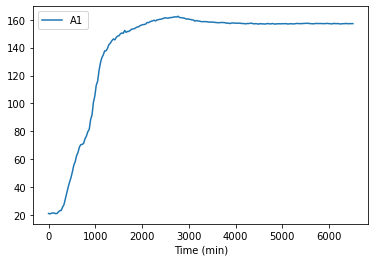

In [4]:
File = os.path.join('data', 'GP_20210507_171028_MTP03_GValue.csv')       #GP_20210507_171028_MTP03_GValue

skiprows = 23
decimal = ','
TimeUnit = 60
Partition = 4

#pd.options.display.max_rows


df = pd.read_csv(File, skiprows=skiprows , decimal=decimal, sep = ",")
#
# df.rename( columns={'Unnamed: 25':'D7'}, inplace=True )
# df.fillna(inplace = True, axis = 1, value = 148.959788)

# print(df.iloc[:,[25,26]])


if 'Input_Image' in list(df.columns):
    df = df.drop(labels='Input_Image', axis=1)
TimeAx = df.columns[0] #'Time (min)' # for growth profiler
Exp0 = df.columns[1]

for column in df.columns:
    if 'Unnamed' in column:
        df.drop(labels= column, axis=1, inplace=True)
        
print('Column headers: ', df.columns)
df.plot(x=TimeAx, y=Exp0)

repnum = 6                 #number of experiments in replicates
GVexp = 1.89
eexp = -9.5
plt.savefig('myPlots.svg', format='svg')

## Single Experiment Analysis

Below, we check individual growth curves and their regression. This can be helpful if you want to examine a particular experiment.

{'R2': 0.9939278022965489, 'Slope': 0.19790699025444056, 'ycorrect': 2.281475224557695, 'time': array([6. , 6.5, 7. , 7.5, 8. ]), 'OD': array([31.594, 35.558, 40.022, 43.575, 46.809])}


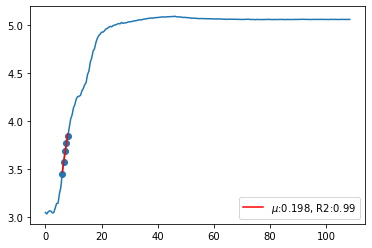

In [10]:
t = df[TimeAx].values/TimeUnit
x = df[Exp0].values
myResult = DetectR2MaxSingle(t,x,Partition)
print(myResult)
plt.plot(t, np.log(x))
if myResult!=False:
    plt.scatter(myResult['time'], np.log(myResult['OD']))
    plt.plot(myResult['time'], myResult['Slope']*myResult['time'] + myResult['ycorrect'], 'r', label='$\mu$:{:.3f}, R2:{:.2f}'.format(myResult['Slope'], myResult['R2']))
    plt.legend()
    myResult['ID'] = Exp0
# myResult

## All Experiment Analysis

Below, all experiments in the csv file are analysed. The final information is stored in plots showing the regression range for each experiment along with the growth rate and the correlation coefficient and stored as `myPlots.svg`. If the regressions look unconvincing, try a different partition.

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6'],
      dtype='object')
bins is false
bins is false
bins is false
bins is false
bins is false


Text(0.1, 0.5, 'ln(OD)')

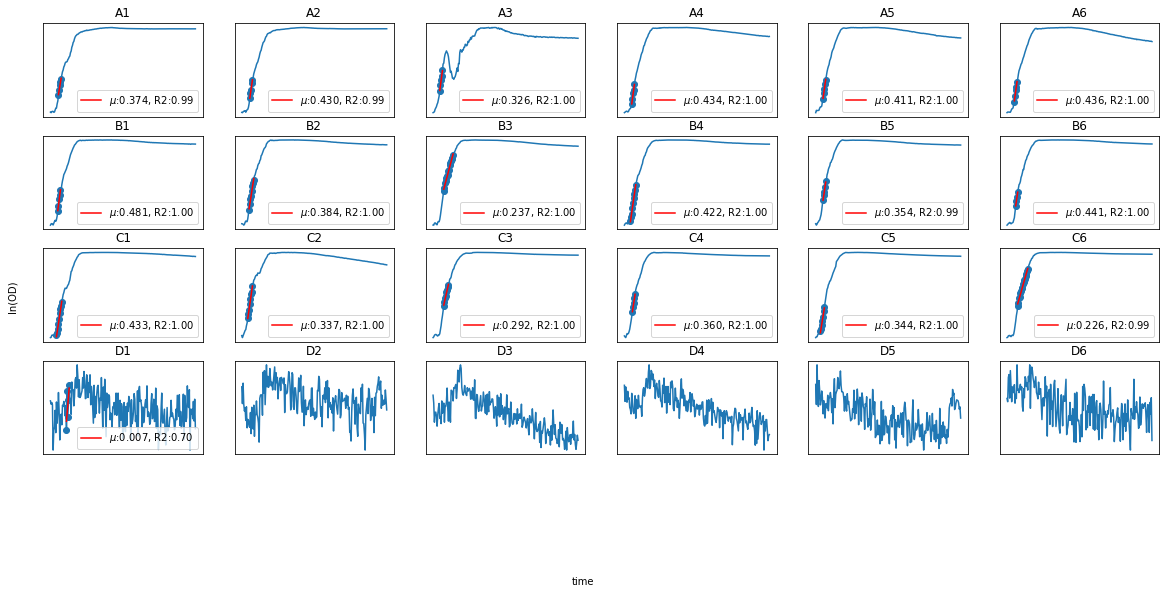

In [11]:
myCols = df.columns[1:]

subplot_x = round(np.sqrt(len(myCols)))
subplot_y = round(np.sqrt(len(myCols))) + 1

OD = pd.DataFrame()
for i1 in myCols: 
    OD[i1] = CorrectedOD(df[i1], GVexp, eexp)
mu_list = []
r2_list = []

NumExp = len(myCols)
AxDim = np.ceil(np.sqrt(NumExp))
t = df[TimeAx].values/TimeUnit
# plt.subplots(AxDim, AxDim, sharex='col')
fig, ax = plt.subplots(figsize=[20,10], sharey=True)
print(myCols)
for idx, myExp in enumerate(myCols):
#print(myExp)
    x = OD[myExp].values
    myResult = DetectR2MaxSingle(t,x,Partition)
    plt.subplot(subplot_x, subplot_y, idx+1)
    plt.plot(t, np.log(x))
    plt.title(myExp)
    if myResult is not False:
        plt.scatter(myResult['time'], np.log(myResult['OD']))
        plt.plot(myResult['time'], myResult['Slope']*myResult['time'] + myResult['ycorrect'], 'r', label='$\mu$:{:.3f}, R2:{:.2f}'.format(myResult['Slope'], myResult['R2']))
        myResult['ID'] = myExp
        plt.legend()
        #hier Dataframe für Mu und R2 feeden
        mu_list.append(myResult['Slope'])
        r2_list.append(myResult['R2'])
    if myResult is False:
        mu_list.append(False)
        r2_list.append(False)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    
fig.text(0.5, 0.1, 'time', ha='center')
fig.text(0.1, 0.5, 'ln(OD)', va='center', rotation='vertical')

In [12]:
statscalc(df, repnum)

              1           2           3         4
0     22.231833   21.851667   23.958167  9.348833
1     22.504333   21.964833   23.849333  9.322000
2     22.716833   22.337500   24.382333  9.354500
3     23.032000   22.474167   25.077667  9.335500
4     23.149667   22.474167   25.549000  9.302333
..          ...         ...         ...       ...
212  131.043500  145.591833  153.214167  9.280000
213  131.166000  145.662167  153.325000  9.289667
214  130.930833  145.405500  153.176667  9.279000
215  130.862500  145.352500  153.222167  9.296833
216  130.749667  145.495333  152.928833  9.258333

[217 rows x 4 columns]
             1         2          3         4
0     2.846175  3.742630   5.859701  1.006795
1     3.000392  3.320010   5.351319  0.997143
2     2.917239  3.303693   5.246005  0.978577
3     3.295697  3.595140   5.681323  0.977800
4     3.575320  3.834014   6.159400  1.011205
..         ...       ...        ...       ...
212  21.587027  5.295792  12.432301  0.984379
213  21.

In [ ]:
# print(df.iloc[:,7:13])

In [ ]:
def severalcsv():
    


In [15]:

csv = pd.DataFrame()
csv['Wells'] = myCols
csv['Mu value'] = mu_list
csv['R2 value'] = r2_list
# csv['mean value'] = mean_list
# csv['stdev'] = stdev_list
csv.to_csv('newcsv.csv')